# Initalize libraries

## Import libraries

In [1]:
import sys, os
import gc
import time
from os.path import join
from os import path
from importlib import reload
from getpass import getuser
from glob import glob
from tqdm.auto import tqdm

# Data
import xarray as xr
import h5py
import numpy as np
from nexusformat.nexus import *
from sfdata import SFDataFiles

# Plotting
import imageio
import matplotlib.pyplot as plt
import fabio
import skimage.morphology

# skimage
from skimage.draw import ellipse

# scipy
from scipy.ndimage.filters import gaussian_filter
import scipy
from scipy import stats

# pyFAI
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector

# Self-written libraries
sys.path.append(join(os.getcwd(), "library"))
import phrcore
import mask_lib
import reconstruct as reco
import fthcore as fth
import support_functions as sup
import interactive
from interactive import cimshow
import reconstruct_rb as rec
import reconstruct as reco

plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

/tmp/ipykernel_475771/2634591437.py:28: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


GPU available


In [2]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    print("GPU available")

    # Self-written library
    import CCI_core_cupy as cci
    import Phase_Retrieval as PhR
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU available


In [3]:
# interactive plotting
import ipywidgets

%matplotlib widget

# Auto formatting of cells
%load_ext jupyter_black

## Experiment specific Functions

In [4]:
BEAMTIMEID = 21626
USER = getuser()

BASEFOLDER = f"/das/home/{USER}/p{BEAMTIMEID}"

### Loading data

In [5]:
mnemonics = dict()
mnemonics["Photon-Energy-PER-PULSE-AVG"] = "SATFE10-PEPG046:PHOTON-ENERGY-PER-PULSE-AVG"
mnemonics["images"] = "SATES20-HOLO-CAM01:FPICTURE"

In [6]:
def split_im_id(scan_id):
    split_fname = scan_id.split("/")
    run = split_fname[1]
    acq = split_fname[-1].split(".")[0]

    return run, acq

In [7]:
def get_im_id(run_nr, acq_nrs):
    fnames = []
    for acq_nr in acq_nrs:
        acq_str = "acq%04d.*.h5" % (acq_nr)

        # Get filename
        fname = join(
            "raw",
            run_nr,
            "data",
            acq_str,
        )
        fnames.append(fname)

    return fnames


def load_run(fnames):

    data = dict()
    N = len(fnames)

    with SFDataFiles(fnames[0]) as f:
        for key in mnemonics.keys():
            data[key] = f[mnemonics[key]].data
    if N > 1:
        for fname in tqdm(fnames[1:]):
            with SFDataFiles(fname) as f:
                for key in mnemonics.keys():
                    # print(key, data[key], f[mnemonics[key]].data)
                    data[key] = np.concatenate((data[key], f[mnemonics[key]].data))
    return data


def load_images(fnames):
    images = []
    N = len(fnames)

    with SFDataFiles(fnames[0]) as f:
        images.append(f[mnemonics["images"]].data)

    if N > 1:
        for fname in tqdm(fnames[1:], desc="Image Stacks"):
            with SFDataFiles(fname) as f:
                images.append(f[mnemonics["images"]].data)
    return images


# Full image loading procedure
def load_processing(im_ids, crop=None):
    """
    Loads images, averaging of two individual images (scans in tango consist of two images),
    padding to square shape, Additional cropping (optional)
    """

    # Load image data
    data = load_run([join(BASEFOLDER, id) for id in im_ids])
    images = data["images"]

    ## Zeropad to get square shape
    # images = sup.padding(images)

    # Calculate mean
    if images.ndim > 2:
        image = np.mean(images, axis=0)
    else:
        image = images.copy()

    # Optional cropping
    if crop is not None:
        images = images[:, :crop, :crop]
        image = image[:crop, :crop]

    return data, image, images

### Loading, saving fth & cdi data

In [8]:
def save_cdi_h5():
    # Save h5
    data = {}
    data["im_id"] = im_id
    data["topo_id"] = topo_id
    data["pos"] = pos
    data["neg"] = neg
    data["factor"] = factor
    data["offset"] = offset
    data["center"] = center
    data["roi"] = roi_cdi
    data["prop_dist"] = prop_dist_cdi
    data["phase"] = phase_cdi
    data["mask_bs"] = mask_bs_cdi
    data["supportmask"] = supportmask
    data["mask_pixel"] = mask_pixel.astype(bool)
    data["p"] = p
    data["n"] = n
    data["p_pc"] = p_pc
    data["n_pc"] = n_pc
    data["experimental_setup"] = experimental_setup

    filename = join(
        folder_target,
        "Logs",
        "Data_ImId_%s_RefId_%s_cdi_%s"
        % (
            im_id,
            topo_id,
            USER,
        ),
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)
    return


# Saving of log files for fth and cdi recos
def save_fth_h5():
    # Save h5
    data = {}
    data["im_id"] = im_id
    data["topo_id"] = topo_id
    data["topo_centered"] = topo_c
    data["im_centered"] = im_c
    data["holo"] = holo
    data["recon"] = recon
    data["factor"] = factor
    data["offset"] = offset
    data["center"] = center
    data["roi"] = roi
    data["prop_dist"] = prop_dist
    data["phase"] = phase
    data["mask_bs"] = mask_bs
    data["mask_pixel"] = mask_pixel.astype(bool)
    data["mask_draw"] = mask_draw.astype(bool)
    data["mask_pixel_smooth"] = mask_pixel_smooth
    data["experimental_setup"] = experimental_setup

    filename = join(
        folder_target,
        "Logs",
        "Data_ImId_%s_RefId_%s_%s"
        % (
            im_id,
            topo_id,
            USER,
        ),
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)


def load_fth(im_id, topo_id):
    """
    Load fth dataset
    """
    fname = join(
        folder_target,
        "Logs",
        "Data_ImId_%s_RefId_%s_%s.hdf5"
        % (
            im_id,
            topo_id,
            USER,
        ),
    )

    with h5py.File(fname, "r") as f:
        data = {}
        for key in f.keys():
            if key != "experimental_setup":
                data[key] = f[key][()]

    return data


def save_cdi_h5():
    # Save h5
    data = {}
    data["im_id"] = im_id
    data["topo_id"] = topo_id
    data["pos"] = pos
    data["neg"] = neg
    data["factor"] = factor
    data["offset"] = offset
    data["center"] = center
    data["prop_dist"] = prop_dist_cdi
    data["phase"] = phase_cdi
    data["mask_bs"] = mask_bs_cdi
    data["supportmask"] = supportmask
    data["mask_pixel"] = mask_pixel
    data["p"] = p
    data["n"] = n
    data["p_pc"] = p_pc
    data["n_pc"] = n_pc
    data["experimental_setup"] = experimental_setup

    filename = join(
        folder_target,
        "Logs",
        "Data_ImId_%s_RefId_%s_cdi_%s"
        % (
            im_id,
            topo_id,
            USER,
        ),
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)
    return


def save_topo_holo(topo_c, pos_id, neg_id):
    """
    Save only topo holos which can be later used for single helicity reconstructions
    """
    data = {}
    data["pos_id"] = pos_id
    data["neg_id"] = neg_id
    data["topo"] = topo_c

    filename = join(
        folder_target,
        "Topos",
        "Topo_ImId_%s_RefId_%s_cdi_%s" % (pos_id, neg_id, USER),
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)
    return


def load_topo_holo(pos_id, neg_id):
    """
    Load topo holos for single helicity reconstructions
    """
    fname = join(
        folder_target,
        "Topos",
        "Topo_ImId_%s_RefId_%s_cdi_%s.hdf5" % (im_id, topo_id, USER),
    )

    with h5py.File(fname, "r") as f:
        im_out = f["topo"][()]
    return im_out


def load_cdi(im_id, topo_id):
    """
    Load cdi dataset
    """
    fname = join(
        folder_target,
        "Logs",
        "Data_ImId_%s_RefId_%s_cdi_%s.hdf5" % (im_id, topo_id, USER),
    )

    with h5py.File(fname, "r") as f:
        data = {}
        for key in f.keys():
            if key != "experimental_setup":
                data[key] = f[key][()]

    return data_cdi

### Other

In [9]:
def drop_inhomogenous_part(image_list):
    # Find length of all image_list stacks
    length = np.array([im.shape[0] for im in image_list])
    max_stack_size = np.min(length)

    for i in range(len(image_list)):
        image_list[i] = image_list[i][:max_stack_size]

    return image_list

In [10]:
def quick_plot(data, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    ax.plot(data)
    ax.grid()

    return fig, ax

In [11]:
# Worker which performs complete fth reconstruction process
def worker(image, topo):
    # Centering
    shift_c = np.array(topo.shape) / 2 - center
    topo_c = cci.shift_image(topo, shift_c)
    im_c = cci.shift_image(image, shift_c)

    ## Image registration
    # shift = cci.image_registration(
    #    im_c[roi_im_reg],
    #    topo_c[roi_im_reg],
    #    method="dipy",
    # )
    shift = [0, 0]
    print("Relative shift is: %s" % shift)

    # Correct relative drift
    topo_c = cci.shift_image(topo_c, shift)

    # Create masks
    # Create image specific beamstop mask
    mask_im = mask_draw.copy()
    mask_im = mask_im + (im_c > experimental_setup["int_cutoff"])
    mask_im[mask_im > 1] = 1

    # Create topo specific beamstop mask
    mask_topo = mask_draw.copy()
    mask_topo = mask_topo + (topo_c > experimental_setup["int_cutoff"])

    # Combine both
    mask_pixel = mask_im + mask_topo
    mask_pixel[mask_pixel > 1] = 1

    # Create smooth mask
    footprint = skimage.morphology.disk(6)
    mask_pixel_smooth = skimage.morphology.dilation(mask_pixel, footprint)
    mask_pixel_smooth = gaussian_filter(mask_pixel_smooth, 2)

    # Get scaling factor and offset
    factor, offset = cci.dyn_factor(
        im_c * (1 - mask_pixel),
        topo_c * (1 - mask_pixel),
        method="correlation",
        print_out=False,
        plot=False,
    )

    # Calculate differences (magnetic) and sums (topographc) contrast holograms.
    # _c: centered, without beamstop, _b: centered, with beamstop
    diff_c = im_c / factor - topo_c - offset
    diff_b = diff_c * mask_bs
    sum_c = im_c / factor + topo_c - offset
    sum_b = sum_c * mask_bs

    # holo = sum_c * mask_bs*(1 - mask_pixel_smooth)
    holo = diff_c * mask_bs * (1 - mask_pixel_smooth)

    # Reconstruct
    recon = cci.reconstruct(
        fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
        * np.exp(1j * phase)
    )

    # worker dictionary
    worker_dict = {}
    worker_dict["center"] = center
    worker_dict["topo_c"] = topo_c
    worker_dict["im_c"] = im_c
    worker_dict["recon"] = recon
    worker_dict["factor"] = factor
    worker_dict["offset"] = offset
    worker_dict["shift"] = shift
    worker_dict["diff_c"] = diff_c
    worker_dict["sum_c"] = sum_c
    worker_dict["mask_bs"] = mask_bs
    worker_dict["mask_pixel"] = mask_pixel

    return worker_dict

In [12]:
# Setup phase and propagation for cdi once
phase_cdi = 0
prop_dist_cdi = 0
dx = 0
dy = 0


def phase_retrieval(
    pos, neg, mask_pixel, supportmask, vmin=0, Startimage=None, Startgamma=None
):
    # Prepare Input holograms
    pos2 = pos.copy()
    neg2 = neg.copy()

    mi, _ = np.percentile(pos2[pos2 != 0], [vmin, 99.9])
    pos2 = pos2 - mi
    mi, _ = np.percentile(neg2[neg2 != 0], [vmin, 99.9])
    neg2 = neg2 - mi

    pos2[pos2 < 0] = 0
    neg2[neg2 < 0] = 0
    pos2 = pos2.astype(complex)
    neg2 = neg2.astype(complex)

    bsmask_p = mask_pixel.copy()
    bsmask_p[pos2 <= 0] = 1
    bsmask_n = mask_pixel.copy()
    bsmask_n[neg2 <= 0] = 1

    # Setup start image and startgamma
    if Startimage is None:
        Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(supportmask)))
    else:
        Startimage = Startimage.copy()
    if Startgamma is None:
        Startgamma = np.ones(pos.shape) * 1e-6 * 2
        Startgamma[pos.shape[0] // 2, pos.shape[1] // 2] = 0.7
    else:
        Startgamma = Startgamma.copy()

    # Settings for phase retrieval reconstructions
    partial_coherence = True

    # Setup
    retrieved_p = np.zeros(pos2.shape, np.cdouble)
    retrieved_n = np.zeros(pos2.shape, np.cdouble)

    # Algorithms and Inital guess
    plt.rcParams["figure.dpi"] = 100
    print("CDI - larger mask")

    algorithm_list = ["mine", "mine", "mine"]
    Nit_list = [700, 50, 50]  # iterations for algorithm_list

    x = (np.sqrt(np.maximum(pos2, np.zeros(pos2.shape)))[mask_pixel == 0]).flatten()
    y = ((np.abs(Startimage))[mask_pixel == 0]).flatten()
    res = stats.linregress(x, y)
    Startimage -= res.intercept
    Startimage /= res.slope

    average_img = 30
    real_object = False  # always set to False

    if partial_coherence:
        RL_freq = 20
        RL_it = 50

        algorithm_list_pc = ["mine", "ER", "ER"]
        Nit_list_pc = [700, 50, 50]

    # Execute Phase retrieval
    start_time = time.time()
    for i in range(len(Nit_list) // 3):
        print("############ -   CDI")

        # Positive helicity - beta_mode="arctan"
        retrieved_p, Error_diff_p, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i],
            beta_zero=0.5,
            Nit=Nit_list[3 * i],
            beta_mode="arctan",
            plot_every=349,
            Phase=Startimage,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Positive helicity - beta_mode="const"
        retrieved_p, Error_diff_p2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 1],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 1],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Negative helicity - beta_mode="arctan"
        retrieved_n, Error_diff_n2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(neg2, np.zeros(neg2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 2],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 2],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p * np.sqrt(np.sum(neg2) / np.sum(pos2)),
            seed=False,
            real_object=real_object,
            bsmask=bsmask_n,
            average_img=average_img,
            Fourier_last=True,
        )

        print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

        Startimage = retrieved_p.copy()

        # Partial coherence phase retrieval
        if partial_coherence:
            # CDI_PC
            print("############   -   CDI_pc")
            pos3 = (np.abs(retrieved_p) ** 2) * bsmask_p + np.maximum(
                pos2, np.zeros(pos2.shape)
            ) * (1 - bsmask_p)
            neg3 = (np.abs(retrieved_n) ** 2) * bsmask_n + np.maximum(
                neg2, np.zeros(neg2.shape)
            ) * (1 - bsmask_n)

            # retrieve pos image
            (
                retrieved_p_pc,
                Error_diff_p_pc,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list_pc[3 * i],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i],
                beta_mode="arctan",
                gamma=Startgamma,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=349,
                Phase=Startimage,
                seed=False,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            (
                retrieved_p_pc,
                Error_diff_p_pc2,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 1],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 1],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )
            (
                retrieved_n_pc,
                Error_diff_n_pc2,
                Error_supp,
                gamma_n,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(neg3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 2],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 2],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc * np.sqrt(np.sum(neg2) / np.sum(pos2)),
                real_object=False,
                bsmask=np.zeros(bsmask_n.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

            Startimage = retrieved_p_pc.copy()
            Startgamma = gamma_p.copy()

    print("Phase Retrieval Done!")

    return (
        retrieved_p,
        retrieved_n,
        retrieved_p_pc,
        retrieved_n_pc,
        bsmask_p,
        bsmask_n,
        gamma_p,
        gamma_n,
    )

In [13]:
def optimize_phase_contrast(recon, supportmask, method="contrast", prefered_color=None):
    """
    Automatically shifts contrast of phase retrieval reconstruction into real part

    Parameter
    =========
    recon : complex array
        FTH/CDI reconstruction plane (Patterson map)
    supportmask : array
        Supportmask of Patterson map for phase retrieval
    method : string
        Choose method for phase optimization ("contrast","minima","maxima")
    prefered_color : string or None
        Shift contrast such that color of domains with largest are is white ("white"),
        black ("black") or non-specific (None)

    Output
    ======
    recon_optimized: complex array
        reconstruction with optimized contrast
    optimized_phase: complex scalar
        phase corresponding to optimized reconstruction
    ======
    author: ck 2023
    """

    # filter references from supportmask
    mask = supportmask.copy()
    mask = mask.astype(bool)
    mask = skimage.morphology.remove_small_objects(mask, min_size=200)
    mask = mask.astype(float)

    # Make object aperture smaller to minimize edge effects
    footprint = skimage.morphology.disk(4)
    mask = skimage.morphology.erosion(mask, footprint)

    # Gaussian filter to remove high intensity peaks
    reco = scipy.ndimage.gaussian_filter(recon, 1)

    # Different functions for optimization
    def contrast(phi, reco, tmask):
        temp = np.imag(reco * np.exp(1j * phi)) * tmask
        mi, ma = np.percentile(temp[temp != 0], [1, 99])
        contrast = ma - mi
        return contrast

    def minima(phi, reco, tmask):
        tmp = np.real(reco * np.exp(1j * phi)) * tmask
        minima, maxima = np.percentile(tmp[tmp != 0], [0.01, 99])
        return minima

    def maxima(phi, reco, tmask):
        tmp = np.real(reco * np.exp(1j * phi)) * tmask
        minima, maxima = np.percentile(tmp[tmp != 0], [0.01, 99])
        return maxima

    # Choose optimization method
    if method == "minima":
        optimized_phase = scipy.optimize.fminbound(
            minima, -np.pi, np.pi, args=(recon, mask), disp=False
        ).astype(float)
    elif method == "contrast":
        optimized_phase = scipy.optimize.fminbound(
            contrast, -np.pi, np.pi, args=(recon, mask), disp=False
        ).astype(float)
    elif method == "max":
        optimized_phase = scipy.optimize.fminbound(
            contrast, -np.pi, np.pi, args=(recon, mask), disp=False
        ).astype(float)

    # Calc optimized reconstruction
    recon_optimized = recon * np.exp(1j * optimized_phase)

    # Optional: Shift phase such that "background" are white or black
    mi_p, ma_p = np.percentile(np.real(recon_optimized[mask == 1]), [1, 99])
    mean = np.mean(np.real(recon_optimized[mask == 1]))
    if prefered_color == "white":
        # Make white domains the dominant domains
        if mean < (mi_p + ma_p) / 2:
            optimized_phase = optimized_phase + np.pi
            recon_optimized = recon * np.exp(1j * optimized_phase)
    elif prefered_color == "black":
        # Make black domains the dominant domains
        if mean > (mi_p + ma_p) / 2:
            optimized_phase = optimized_phase + np.pi
            recon_optimized = recon * np.exp(1j * optimized_phase)

    return recon_optimized, optimized_phase

# Experimental Details

In [14]:
# Dict with most basic experimental parameter
experimental_setup = {
    "ccd_dist": 0.20,  # ccd to sample distance
    "px_size": 13.5e-6,  # pixel_size of camera
    "binning": 1,  # Camera binning
    "energy": 778,  # photon energy
    "int_cutoff": 40e3,  # Camera saturation threshold
}
experimental_setup["lambda"] = cci.photon_energy_wavelength(
    experimental_setup["energy"], input_unit="eV"
)

# Setup for azimuthal integrator
detector = Detector(
    experimental_setup["binning"] * experimental_setup["px_size"],
    experimental_setup["binning"] * experimental_setup["px_size"],
)

# General saving folder and log folder
folder_target = sup.create_folder(join(BASEFOLDER, "work", "Analysis"))
sup.create_folder(join(folder_target, "Logs"))
sup.create_folder(join(folder_target, "Topos"))
print("Output Folder: %s" % folder_target)

Output Folder: /das/home/ext-klose_c/p21626/work/Analysis


# Load images

Start by loading the images: image of interest (im), reference of charge scattering (topo), any kind of dark image (dark)

We estalished the following convention: Difference Hologram which contains only the magnetic scattering will be calculated according to:

$Diff = \frac{Image}{factor} - Topo$,

where the factor is used for intensity scaling. In Case that you recorded scans of the same magnetic state with both helicities, use the image with negative helicity as topo and the one with positive helicity as image

In [15]:
# Full image loading procedure
def load_processing_frames(ids, crop=None):
    """
    Loads images, averaging of two individual images (scans in tango consist of two images),
    padding to square shape, Additional cropping (optional)
    """

    # Basic loading of stacks into list
    images = load_images([join(BASEFOLDER, idx) for idx in ids])

    # Make number of frames in each stack consistent
    images = drop_inhomogenous_part(images)
    gc.collect()

    # Combine into 3d np array
    images = np.vstack(images)

    # Calculate mean
    if images.ndim > 2:
        image = np.mean(images, axis=0)
    else:
        image = images.copy()

    # Optional cropping
    if crop is not None:
        images = images[:, :crop, :crop]
        image = image[:crop, :crop]

    return image, images

In [16]:
im_id = "run0003-test_hologram_gain_mode_1_gain_0"
acq_nrs = np.arange(1, 100 + 1)  # [1, 2]
ids = get_im_id(im_id, acq_nrs)

In [ ]:
image, _ = load_processing_frames(ids, crop=None)

# Plot
fig, ax = cimshow(image)
ax.set_title("Image")

/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "DPO:FrameNumber" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/DPO:FrameNumber" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "DPO:Repetitions" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/DPO:Repetitions" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "SATES21-XSMA166:MOT1:MOTRBV" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/SATES21-XSMA166:MOT1:MOTRBV" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/p

Image Stacks:   0%|          | 0/99 [00:00<?, ?it/s]

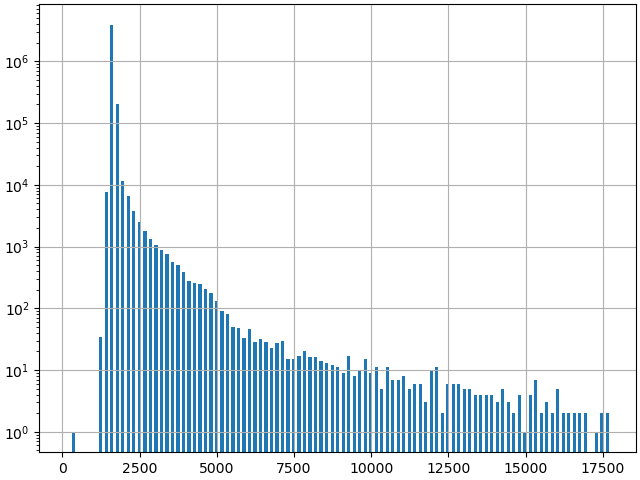

In [39]:
nr_bins = 100
bins = np.linspace(0, np.max(image), nr_bins)
counts, edges = np.histogram(image, bins=bins)


fig, ax = plt.subplots()
ax.bar(edges[1:], counts, width=nr0)
ax.grid()
ax.set_yscale("log")

## Load topo data set and average

In [19]:
topo_id = "None"  # placeholder
acq_nrs = np.arange(1, 10 + 1)  # [1, 2]
ids = get_im_id(topo_id, acq_nrs)

In [20]:
topo = np.zeros_like(image)

In [17]:
topo, _ = load_processing_frames(ids, crop=None)

# Plot
fig, ax = cimshow(topo)
ax.set_title("Topo")

/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "DPO:FrameNumber" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/DPO:FrameNumber" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "DPO:Repetitions" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/DPO:Repetitions" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "SATES21-XSMA166:MOT1:MOTRBV" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/SATES21-XSMA166:MOT1:MOTRBV" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/p

  0%|          | 0/98 [00:00<?, ?it/s]

## Load dark image

In [22]:
dark_id = "run0005-dark"
acq_nrs = np.arange(1, 10 + 1)  # [1, 2]
ids = get_im_id(dark_id, acq_nrs)

/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "DPO:FrameNumber" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/DPO:FrameNumber" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "DPO:Repetitions" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/DPO:Repetitions" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/python3.11/site-packages/sfdata/sfdatafile.py:107: UserWarning: Skipping channel "SATES21-XSMA166:MOT1:MOTRBV" since it caused DatasetNotInGroupError: Cannot get dataset "data" from: <HDF5 group "/SATES21-XSMA166:MOT1:MOTRBV" (0 members)>
  print_skip_warning(exc, cn)
/das/home/ext-klose_c/p21626/work/ck/2404_SwissFEL_venv/lib/p

Image Stacks:   0%|          | 0/9 [00:00<?, ?it/s]

interactive(children=(FloatRangeSlider(value=(1407.079352, 1680.152), description='contrast', layout=Layout(wi…

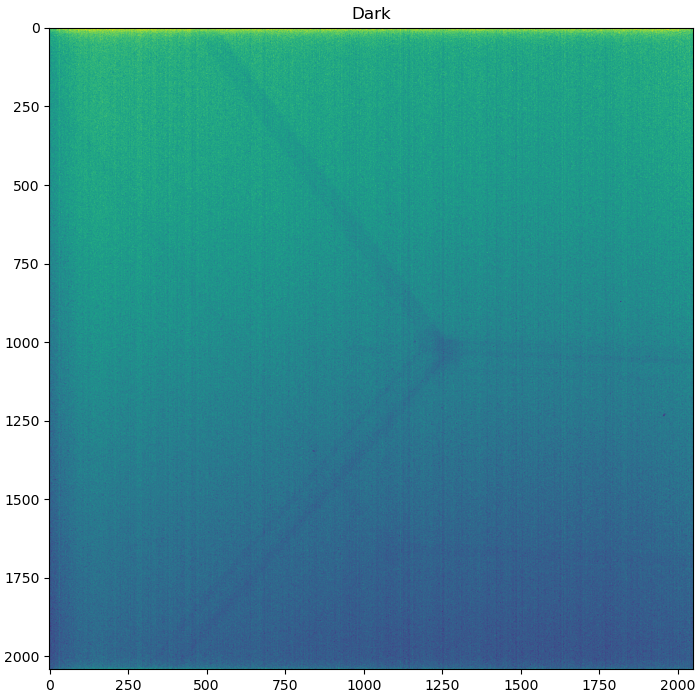

In [23]:
# Load image
if dark_id is not None:
    dark, _ = load_processing_frames(ids, crop=None)

    # Subtract dark
    image = image - dark
    topo = topo - dark

    # Plot
    fig, ax = cimshow(dark)
    ax.set_title("Dark")

interactive(children=(FloatRangeSlider(value=(-8.297664800000105, 1727.611800000143), description='contrast', …

Text(0.5, 1.0, 'Image with subtracted dark')

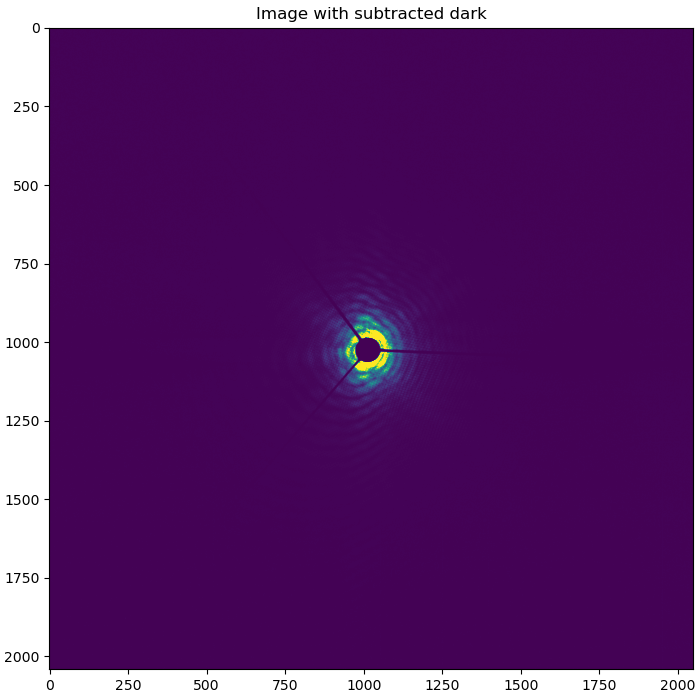

In [24]:
# Plot
fig, ax = cimshow(image)
ax.set_title("Image with subtracted dark")

# Center holograms

* Find center of the hologram to get a well-defined q-space. 
* Create smooth mask for beamstop or overexposed areas in direct beam

## Basic widget to find center

Try to **align** the circles to the **center of the scattering pattern**. Care! Position of beamstop might be misleading and not represent the actual center of the hologram. Circles are just a guide to eye and will not be used otherwise.

interactive(children=(FloatRangeSlider(value=(-8.297664800000105, 1727.611800000143), description='contrast', …

interactive(children=(IntText(value=1028, description='c0 (vert)', step=0), IntText(value=1007, description='c…

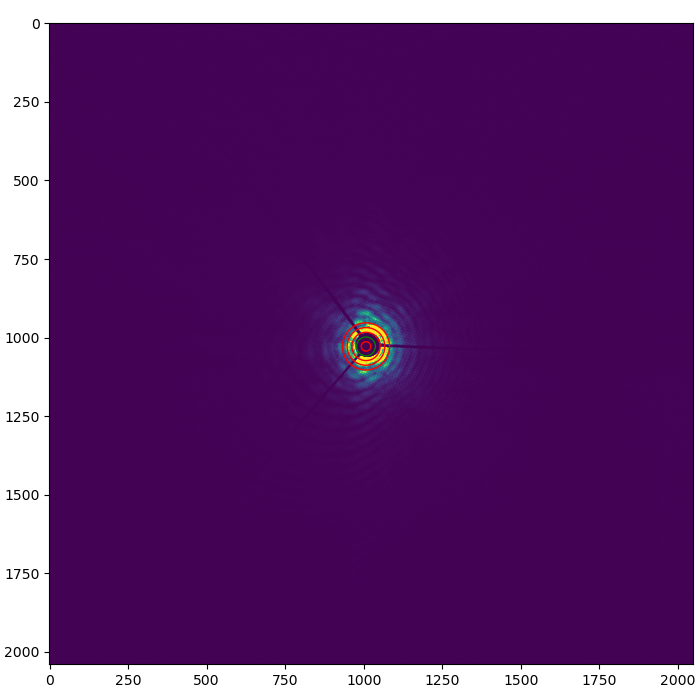

In [25]:
# Find center position via widget
c0, c1 = [1028, 1007]  # initial values
# ic = interactive.InteractiveCenter(np.log10(image-np.min(image)+1), c0=c0, c1=c1)
ic = interactive.InteractiveCenter(image, c0=c0, c1=c1)

In [26]:
# Get center positions
center = [ic.c0, ic.c1]
print(f"Center:", center)

Center: [1028, 1007]


## Azimuthal integrator widget for finetuning
More of an "expert widget" which works very well for alignment if you have an Airy Pattern as a scattering image. PyFai transforms images from carthesian detector coordinate system into polar coordinate system with angle `phi` and radial distance `q` as axis (azimuthal transformation). The center of the coordinate system will be defined in the azimuthal integrator class and must not necessarily represents the center coordinates of your image array. If the center is set correctly, all rings of the Airy pattern will be transformed into a straight line in the I(q,chi)-plot as rings appear at a given q for all angles chi.

In [27]:
# Setup azimuthal integrator for virtual geometry
ai = AzimuthalIntegrator(
    dist=experimental_setup["ccd_dist"],
    detector=detector,
    wavelength=experimental_setup["lambda"],
    poni1=center[0]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # y (vertical)
    poni2=center[1]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # x (horizontal)
)

Text(0.5, 1.0, 'Azimuthal integration')

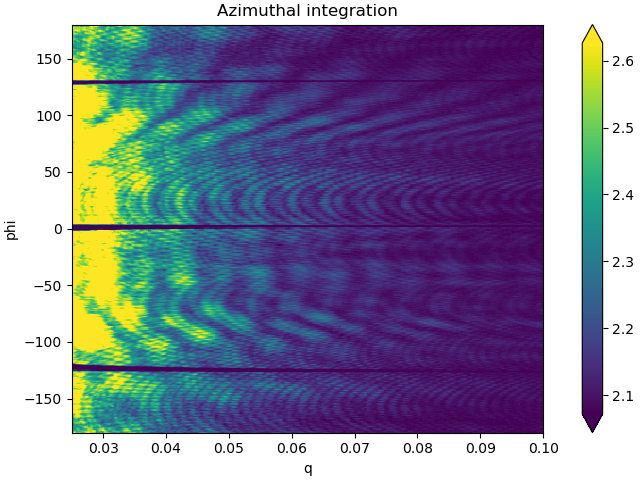

In [28]:
# Not the widget, just for double checking to find correct radial range for plotting
# Perform azimuthal transformation
I_t, q_t, phi_t = ai.integrate2d(
    np.log10(image - np.min(image) + 1),
    500,  # number of points for phi
    radial_range=(0.025, 0.1),  # relevant q-range
    unit="q_nm^-1",
    correctSolidAngle=False,
    method="BBox",
)
# Combine in an xarray for plotting
az2d = xr.DataArray(I_t, dims=("phi", "q"), coords={"q": q_t, "phi": phi_t})

# Plot
fig, ax = plt.subplots()
mi, ma = np.percentile(I_t, [1, 95])
az2d.plot.imshow(ax=ax, vmin=mi, vmax=ma)
plt.title(f"Azimuthal integration")

Left: 1d azimuthal Integration I(q)
Right: 2d azimuthal Integration I(q,chi)
Use arrow buttons on keyboard to adjust center position after selecting a slider.
Try to transform all rings of the Airy pattern into a straight line in the 2d I(q,chi)-plot. Maximize fringe contrast in 1d I(q) plot for fine-tuning.


interactive(children=(FloatSlider(value=1028.0, description='y-center', layout=Layout(width='500px'), max=1360…

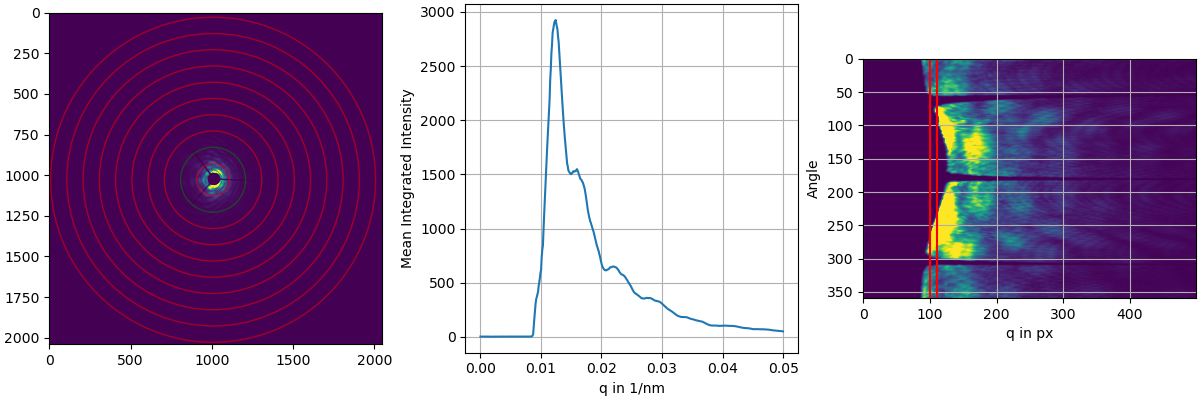

In [29]:
# The widget
aic = interactive.AzimuthalIntegrationCenter(
    # np.log10(image-np.min(image)+1),
    image,
    ai,
    c0=center[0],
    c1=center[1],
    im_data_range=[1, 98],
    radial_range=(0.0, 0.05),
    qlines=[100, 110],
)

In [30]:
# Get center positions from widget
center = [aic.c0, aic.c1]
print(f"Center:", center)

Center: [1028.0, 1007.0]


## Centering of image hologram

In [31]:
# Apply to topo and image
shift_c = np.array(image.shape) / 2 - center
im_c = cci.shift_image(image, shift_c)
topo_c = cci.shift_image(topo, shift_c)  # centered image

# Image Registration

Relative drift between data holograms and their corresponding topo holograms is calculated by image registration algorithm. Necessary to get well defined difference hologram. The reference is always the static background image (topo).

## Set Alignment ROI 

Set a region of interest (ROI) of reference (topo) use for image registration is performed. Can include beamstop when beamstop mask was defined.

How to use:
1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

interactive(children=(FloatRangeSlider(value=(-8.304864800000098, 1727.6118000001434), description='contrast',…

Text(0.5, 1.0, "Don't include the beamstop as this will misdirect the algorithm")

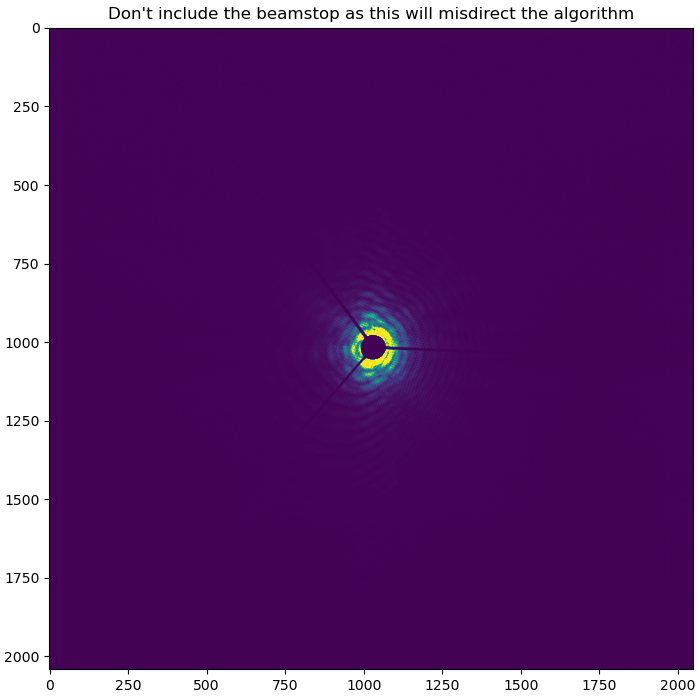

In [32]:
fig, ax = cimshow(im_c)
ax.set_title("Don't include the beamstop as this will misdirect the algorithm")

In [33]:
# Takes start and end of x and y axis
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()
roi_im_reg = np.array([y1, y2, x1, x2]).astype(int)
roi_im_reg_s = np.s_[roi_im_reg[0] : roi_im_reg[1], roi_im_reg[2] : roi_im_reg[3]]

print(f"Image registration roi:", roi_im_reg)

Image registration roi: [   0 2039    0 2047]


## Calculate drift of images

In [ ]:
shift = cci.image_registration(
    im_c[roi_im_reg_s],
    topo_c[roi_im_reg_s],
    method="dipy",
)
print("Relative shift is: %s" % shift)

In [ ]:
# Define shift manually for comparison
tmp_shift = [0.03, 0.02]

# Loop over shifts
temp_diff = np.zeros((3, im_c.shape[0], im_c.shape[1]))
shifts = [
    [0, 0],
    tmp_shift,
    -shift,
]
for i, tshift in enumerate(shifts):
    temp = cci.shift_image(im_c, shift)
    temp_factor = cci.dyn_factor(temp, topo_c)
    temp_diff[i] = temp - temp_factor[0] * topo_c

# Plots for comparision
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
mi, ma = np.percentile(temp_diff[0], [0.1, 99.9])
ax[0].imshow(temp_diff[0], vmin=mi, vmax=ma)
ax[0].set_title("Zero shift")
mi, ma = np.percentile(temp_diff[1], [0.1, 99.9])
ax[1].imshow(temp_diff[1], vmin=mi, vmax=ma)
ax[1].set_title("Manual shift: %s" % shifts[1])
mi, ma = np.percentile(temp_diff[2], [0.1, 99.9])
ax[2].imshow(temp_diff[2], vmin=mi, vmax=ma)
ax[2].set_title("Auto shift: %s" % np.round(shifts[2], 2))

In [34]:
# If the shift is very small you might want to set it to [0,0]
# as this prevents some artifacts
shift = [0, 0]

## Correct drift of topo

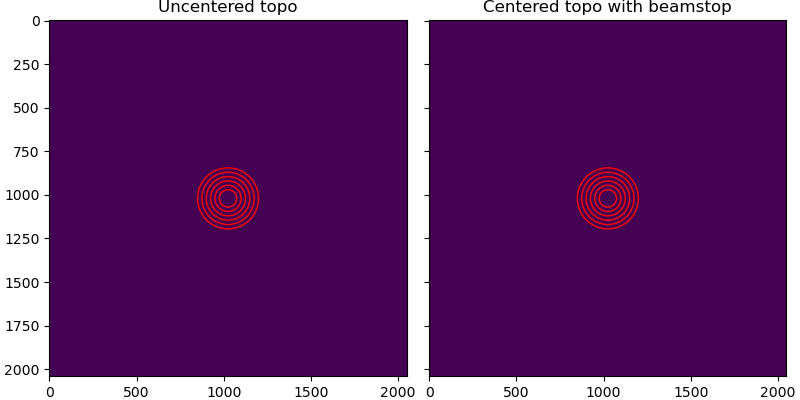

In [35]:
# Correct relative drift
topo_c = cci.shift_image(topo_c, shift)

# Plot original and shifted holos
mi, ma = np.percentile(np.real(im_c[im_c != 0]), (0.1, 99))
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
ax[0].imshow(np.real(topo), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Uncentered topo")
ax[1].imshow(np.real(topo_c), cmap="viridis", vmin=mi, vmax=ma)
ax[1].set_title("Centered topo with beamstop")

# Add circles with different radi r
tmp = np.array(image.shape) / 2
for r in np.arange(50, 200, 25):
    ax[0].add_artist(plt.Circle((tmp[1], tmp[0]), r, fill=None, ec="red"))
    ax[1].add_artist(plt.Circle((tmp[1], tmp[0]), r, fill=None, ec="red"))

# Create beamstops

We want to cover the beamstop with a smooth circle to cover its sharp edges as these would create ringing-like artifacts in the reconstruction plane. Make it only as large as necessary to keep as much information as possible.

## Circle beamstop

Set beamstop diameter and std for smoothing filter. Higher values mean stronger smoothing. If you have a very small beamstop you might need to reduce the smoothing value. Otherwise the sharp gradient of the real beamstop will still be visible

interactive(children=(FloatRangeSlider(value=(-8.304864800000098, 186.44259200000036), description='contrast',…

interactive(children=(IntText(value=55, description='radius'), IntText(value=3, description='smoothing'), Outp…

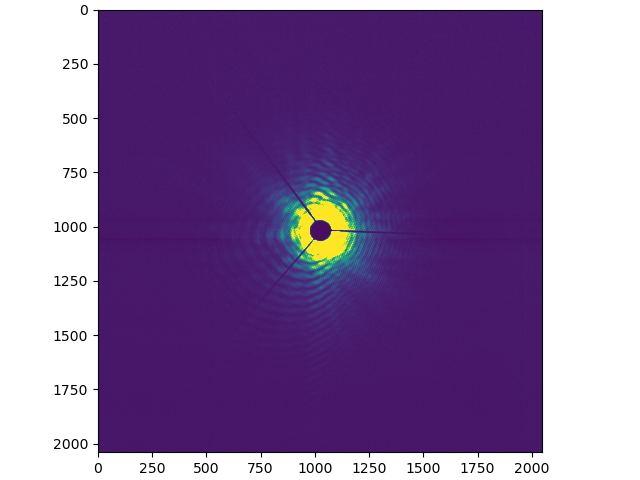

In [36]:
bs = interactive.InteractiveBeamstop(
    im_c, im_c.shape[0] / 2, im_c.shape[1] / 2, rBS=55, stdBS=3
)

Text(0.5, 1.0, '1 - Beamstop mask')

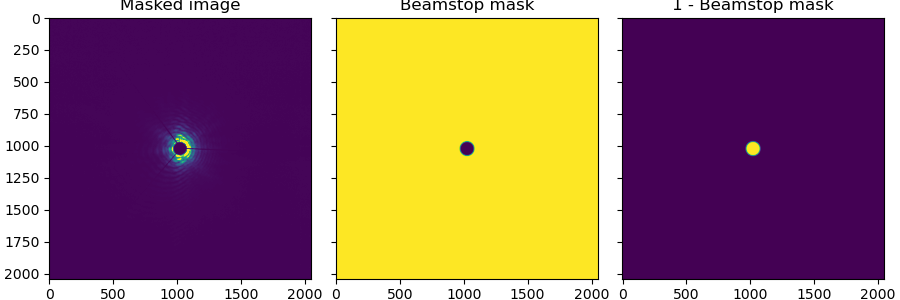

In [37]:
# Take value from widget and create beamstop mask
bs_diam = bs.rBS
bs_smoothing = bs.stdBS
mask_bs = 1 - mask_lib.circle_mask(
    topo.shape, np.array(topo.shape) / 2, bs.rBS, sigma=bs_smoothing
)

# Apply beamstop to image
im_b = im_c * mask_bs

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(im_b, [0.1, 99.9])
ax[0].imshow(im_b, cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Masked image")

ax[1].imshow(mask_bs)
ax[1].set_title("Beamstop mask")

ax[2].imshow(1 - mask_bs)
ax[2].set_title("1 - Beamstop mask")

## Manual masking of beamstop wires

Just mask the beamstop wires, broken pixels, etc. 

interactive(children=(FloatRangeSlider(value=(-19.653230159999996, 5531.077742794445), description='contrast',…

Click on the figure to create a polygon corner.
Click `Add mask` to store coordinates and apply mask.
Press the 'esc' key to reset the polygon for new drawing.

Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.
Button `Delete mask` deletes the masks recursively.


Button(button_style='warning', description='Add mask', layout=Layout(height='auto', width='100px'), style=Butt…

Button(description='Delete mask', layout=Layout(height='auto', width='100px'), style=ButtonStyle())

Output()

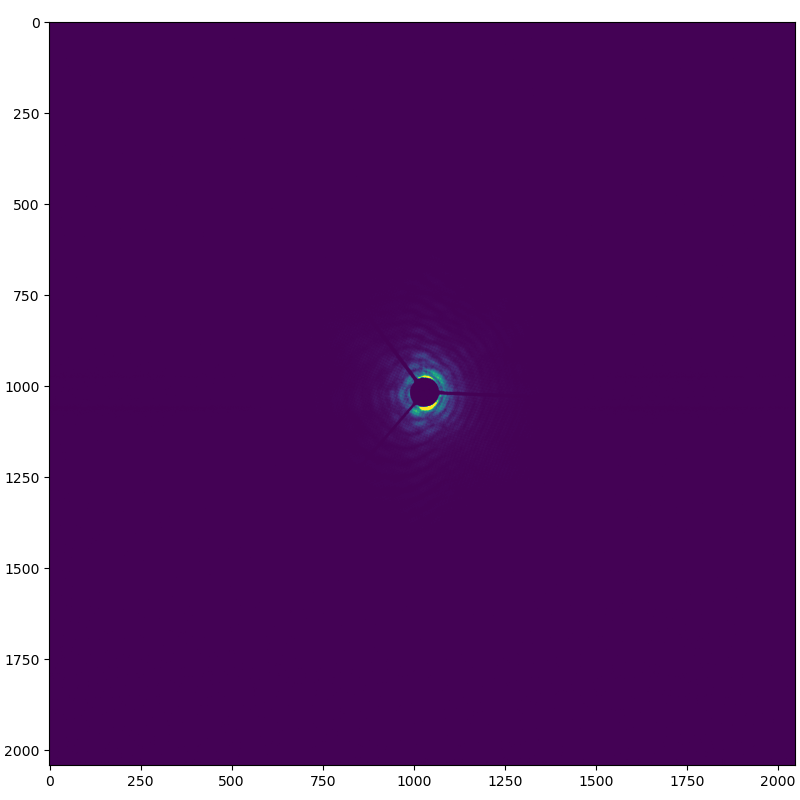

In [38]:
poly_mask = interactive.draw_polygon_mask(im_c)

Copy these coordinates into the 'load_poly_coordinates()' function:
[]


Text(0.5, 1.0, '1 - mask_draw')

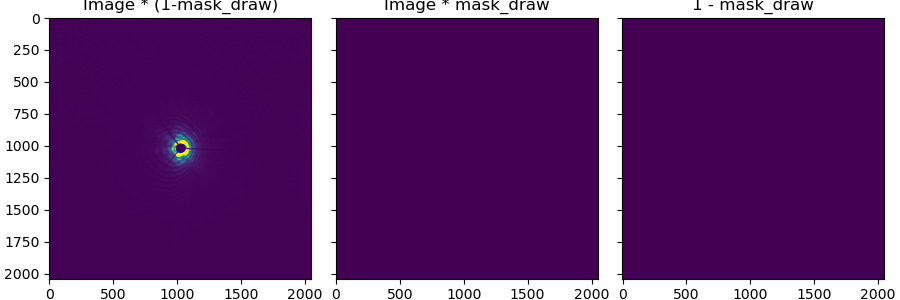

In [39]:
# Take poly coordinates and mask from widget
p_coord = poly_mask.get_vertice_coordinates()
mask_draw = poly_mask.full_mask.astype(int)

print("Copy these coordinates into the 'load_poly_coordinates()' function:")
print(p_coord)

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(im_c * (1 - mask_draw), [0.1, 99.9])
ax[0].imshow(im_c * (1 - mask_draw), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Image * (1-mask_draw)")

mi, ma = np.percentile(im_c * mask_draw, [0.1, 99.9])
ax[1].imshow(im_c * mask_draw, vmin=mi, vmax=ma)
ax[1].set_title("Image * mask_draw")

ax[2].imshow(1 - mask_draw)
ax[2].set_title("1 - mask_draw")

In [40]:
def load_poly_coordinates():
    """
    Dictionary that stores polygon corner coordinates of all drawn masks
    Example: How to add masks with name "test":
    mask_coordinates["test"] = copy coordinates from above
    """

    # Setup dictonary
    mask_coordinates = dict()

    # Mask #1
    mask_coordinates["bs_test"] = [
        [
            (930.9, 606.4),
            (88.0, 1929.8),
            (208.8, 1998.4),
            (282.9, 1981.9),
            (1073.7, 1114.3),
            (1988.0, 1169.2),
            (1938.5, 938.6),
            (1106.6, 908.4),
            (392.7, 5.1),
            (151.1, 57.2),
        ],
        [(1260.4, 1652.1), (1603.6, 1476.4), (1526.7, 1350.1), (1147.8, 1330.9)],
    ]
    return mask_coordinates

Text(0.5, 1.0, '1 - mask_draw')

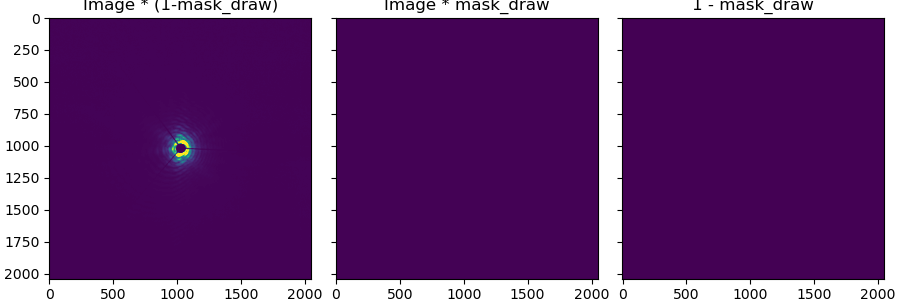

In [41]:
# Which drawn masks do you want to load? You can combine multiple masks from
# load_poly_coordinates(). Just add names of mask as strings to list like
# ["bs_small","bs_medium"]
polygon_names = []  # ["bs_test"]
mask_draw = mask_lib.load_poly_masks(
    im_c.shape,
    load_poly_coordinates(),
    polygon_names,
)

# Expand/shrink Mask if necessary
# footprint = skimage.morphology.disk(3)
# mask_draw = skimage.morphology.dilation(mask_draw, footprint) # increase size
# mask_draw = skimage.morphology.erosion(mask_draw, footprint) # decrease size

# The relative position of the drawn beamstop with respect to the actual beamstop
# might change due to sample change, sample drift, realignment, etc. The drawn
# beamstop mask would therefore not cover the actual beamstop position. This function
# aligns the beamstop mask with respect to the actual position
optimize_position = False

# Optimize position of drawn mask relative to target image
if optimize_position is True:
    # level 1 (rough)
    optimized_shift, mask_shifted, _ = auto_shift_mask(
        mask_draw,
        im_c,
        shift_range_y=[-10, 10],
        shift_range_x=[-10, 10],
        step_size=4,
        crop=300,
    )
    ## Level 2 (fine)
    optimized_shift, mask_shifted, overlap = auto_shift_mask(
        mask_draw,
        im_c,
        shift_range_y=[optimized_shift[0] - 4, optimized_shift[0] + 4],
        shift_range_x=[optimized_shift[1] - 4, optimized_shift[1] + 4],
        step_size=0.5,
        crop=300,
    )
    mask_draw = mask_shifted.copy()

# Shift mask
# mask_draw = np.round(cci.shift_image(mask_draw,[2,0]))

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(im_c * (1 - mask_draw), [0.1, 99.9])
ax[0].imshow(im_c * (1 - mask_draw), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Image * (1-mask_draw)")

# mi, ma = np.percentile(im_c * mask_draw, [0.1, 90])
ax[1].imshow(im_c * mask_draw, vmin=mi, vmax=ma)
ax[1].set_title("Image * mask_draw")

ax[2].imshow(1 - mask_draw)
ax[2].set_title("1 - mask_draw")

## Finetuning of mask position

In [ ]:
# Use widget to shift and expand or shrink the mask
ss_mask = interactive.Shift_Scale_Mask(im_c, mask_draw)

In [ ]:
# Take mask, shift and scaling from widget
mask_draw, mask_shift, mask_scale = ss_mask.get_mask()

## Overview beamstops
Verify good beamstop alignment

Text(0.5, 1.0, 'Image-Topo')

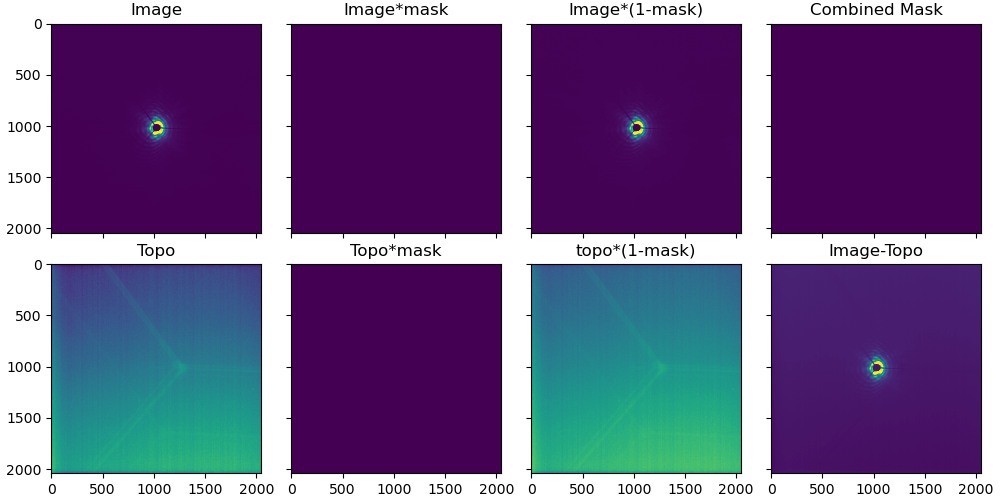

In [42]:
# Add circular beamstop mask
mask_im = mask_draw.copy()
mask_topo = mask_im.copy()

# Mask over-saturated pixel
mask_im = mask_im + (im_c > 40000)
mask_topo = mask_topo + (topo_c > 40000)

# Combine both
mask_pixel = mask_im + mask_topo
mask_pixel[mask_pixel > 1] = 1

# Create smooth mask for FTH reconstructions
footprint = skimage.morphology.disk(6)
mask_pixel_smooth = skimage.morphology.dilation(mask_pixel, footprint)
mask_pixel_smooth = gaussian_filter(mask_pixel_smooth, 2)

# Plot both
fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
mi, ma = np.percentile(im_c, [1, 99.9])
ax[0, 0].imshow(im_c, vmin=mi, vmax=ma)
ax[0, 0].set_title("Image")
mi, ma = np.percentile(im_c * mask_im, [1, 99.99])
ax[0, 1].imshow(im_c * mask_im, vmin=mi, vmax=ma)
ax[0, 1].set_title("Image*mask")
mi, ma = np.percentile(im_c * (1 - mask_im), [0.1, 99.9])
ax[0, 2].imshow(im_c * (1 - mask_im), vmin=mi, vmax=ma)
ax[0, 2].set_title("Image*(1-mask)")
ax[0, 3].imshow(mask_pixel_smooth)
ax[0, 3].set_title("Combined Mask")

mi, ma = np.percentile(topo_c, [1, 99.9])
ax[1, 0].imshow(topo_c, vmin=mi, vmax=ma)
ax[1, 0].set_title("Topo")
mi, ma = np.percentile(topo_c * mask_im, [1, 99.99])
ax[1, 1].imshow(topo_c * mask_topo, vmin=mi, vmax=ma)
ax[1, 1].set_title("Topo*mask")
mi, ma = np.percentile(topo_c * (1 - mask_topo), [0.1, 99.9])
ax[1, 2].imshow(topo_c * (1 - mask_topo), vmin=mi, vmax=ma)
ax[1, 2].set_title("topo*(1-mask)")
mi, ma = np.percentile((im_c - topo_c) * (1 - mask_pixel_smooth), [0.1, 99.9])
ax[1, 3].imshow((im_c - topo_c) * (1 - mask_pixel_smooth), vmin=mi, vmax=ma)
ax[1, 3].set_title("Image-Topo")

# Calculate difference holograms

You can see the reconstrution of the magnetization only after subtracting the large background that you get from the diffraction on the circular object aperture (Airy Pattern). This might require a scaling factor to correct intensity changes between the hologram and the topo. Scaling factor will be determined automatically by a linear fit. If the fit seems off, there might be an issue with the data

In [59]:
# Get scaling factor and offset
factor, offset = cci.dyn_factor(
    im_c * (1 - mask_pixel),
    topo_c * (1 - mask_pixel),
    method="correlation",
    print_out=True,
    plot=True,
)

# Calculate differences (magnetic) and sums (topographc) contrast holograms.
# _c: centered, without beamstop, _b: centered, with beamstop
diff_c = im_c / factor - topo_c - offset
diff_b = diff_c * mask_bs
sum_c = im_c / factor + topo_c - offset
sum_b = sum_c * mask_bs

ValueError: `ydata` must not be empty!

In [43]:
diff_c = im_c.copy()

interactive(children=(FloatRangeSlider(value=(-8.304864800000098, 1727.6118000001434), description='contrast',…

Text(0.5, 1.0, ' Diff Id run0003-test_hologram_gain_mode_1_gain_0 - None')

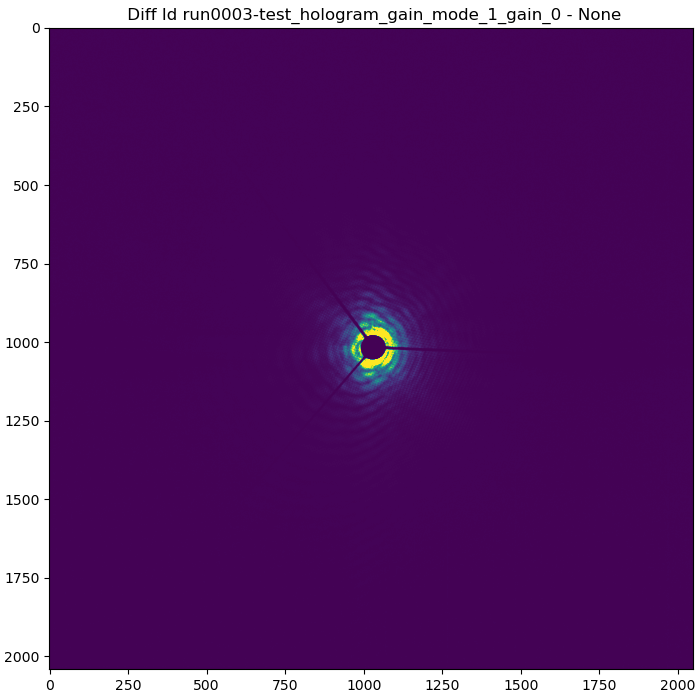

In [44]:
# Plot an example of the difference or sum hologram
fig, ax = cimshow(diff_c * (1 - mask_pixel_smooth))
ax.set_title(f" Diff Id %s - %s" % (im_id, topo_id))

# fig, ax = cimshow(sum_b)
# ax.set_title(f" Sum Id %d" % im_id)

# Reconstruct Diff Holos (FTH)

Reconstruct the hologram.

0. If you are doing heraldo, determine the rotation angle of the hologram
1. Choose a region of interest (ROI) which means selecting one reconstruction from the reconstruction plane.
2. Propagate the image and shift the phase for maximal contrast and sharpness in your ROI

## Set Patterson Map ROI

Choose the reconstructions as the ROI.

1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

interactive(children=(FloatRangeSlider(value=(-0.19709486630159542, 0.20431879981616224), description='contras…

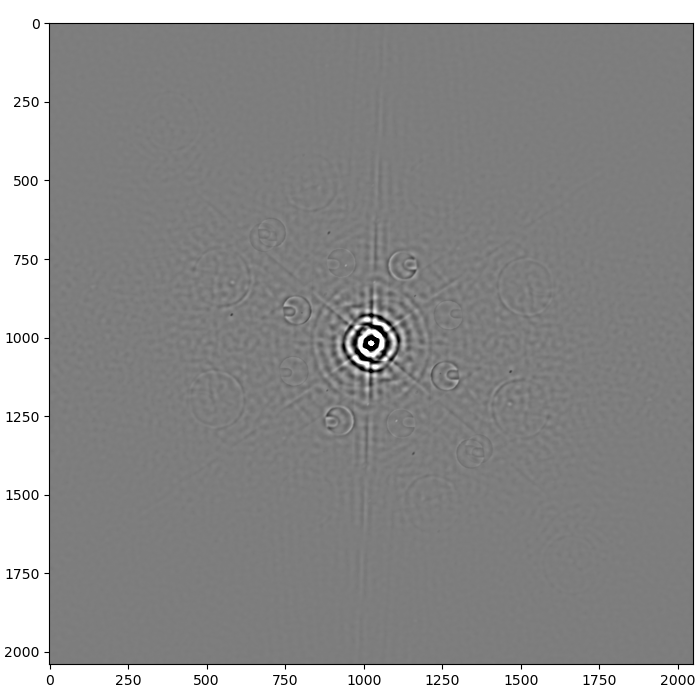

In [52]:
# Choose contrast mode
# diff_c: magnetic contrast only
# sum_c: topographic contrast only
holo = diff_c * mask_bs * (1 - mask_pixel_smooth)
# holo = sum_c * mask_bs * (1 - mask_pixel_smooth)
# holo = im_c * mask_bs * (1 - mask_pixel_smooth)

fig, ax = cimshow(np.real(fth.reconstruct(holo)), cmap="gray")

In [53]:
# Execute to get roi
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()
roi = np.array([y1, y2, x1, x2]).astype(int)  # ystart, ystop, xstart, xstop
# roi = [612, 825, 705, 898]
roi_s = np.s_[roi[0] : roi[1], roi[2] : roi[3]]
print(f"Roi Reco:{roi}")

Roi Reco:[1056 1163  723  836]


## Tune propagation and phase
Focus the image by tuning the propagation distance. This really works like focussing in a microscope.
Phase slider will move contrast between real and imaginary part. Usually we use the phase which maximizes the contrast in the real part.

interactive(children=(FloatSlider(value=0.0, description='propagation[um]', layout=Layout(width='90%'), max=10…

Button(description='Finished', style=ButtonStyle())

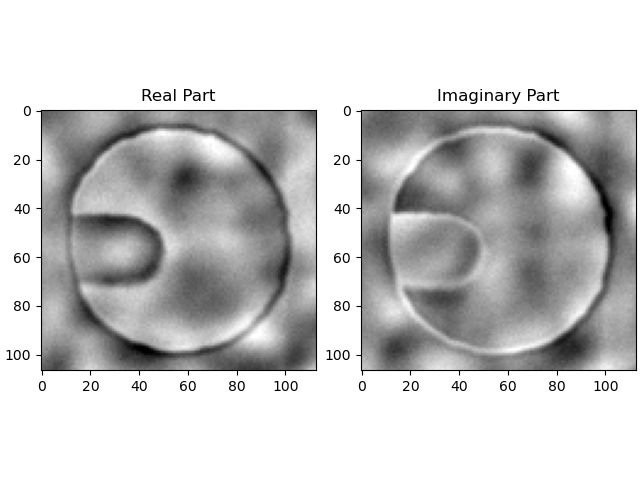

In [54]:
# Widget
slider_prop, slider_phase, button = reco.propagate(
    holo,
    roi_s,
    phase=0,  # Initial value
    prop_dist=0,  # Initial value
    experimental_setup=experimental_setup,
    scale=(0.1, 99.9),
)

In [55]:
# Read prop dist and phase from widget
prop_dist = slider_prop.value
phase = slider_phase.value

print(f"Propagation distance: %0.2f" % prop_dist)
print(f"Phase: %0.2f" % phase)

Propagation distance: 0.29
Phase: 0.34


## Save reconstruction

Save png files of the images and a h5 file containing all important variables

In [56]:
# Style of reconstruction plot
def plot_recon(recon, title):
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title)

    vmin, vmax = np.percentile(np.real(recon), (1, 99))
    t_im1 = ax[0].imshow(np.real(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[0].set_title("Real")
    plt.colorbar(t_im1, ax=ax[0], aspect=50)

    vmin, vmax = np.percentile(np.imag(recon), (1, 99))
    t_im2 = ax[1].imshow(np.imag(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[1].set_title("Imag")
    plt.colorbar(t_im2, ax=ax[1], aspect=50)

In [57]:
def get_title(data_key, im_id, topo_id, CDI=False):
    # Rotation in title
    # values = np.mean(np.array(load_pre_scan_snapshot(im_id, data_key)) * 1000)
    # values = [np.round(values, 2)]

    # Rotation in title
    # values = load_pre_scan_snapshot(im_id, data_key)

    if CDI is False:
        mode = "FTH"
    elif CDI is True:
        mode = "CDI"

    if data_key == None:
        title = "%s: %s - %s" % (mode, im_id, topo_id)

    return title

Saving: /das/home/ext-klose_c/p21626/work/Analysis/Recon_ImId_run0003-test_hologram_gain_mode_1_gain_0_RefId_None_ext-klose_c.png


NameError: name 'factor' is not defined

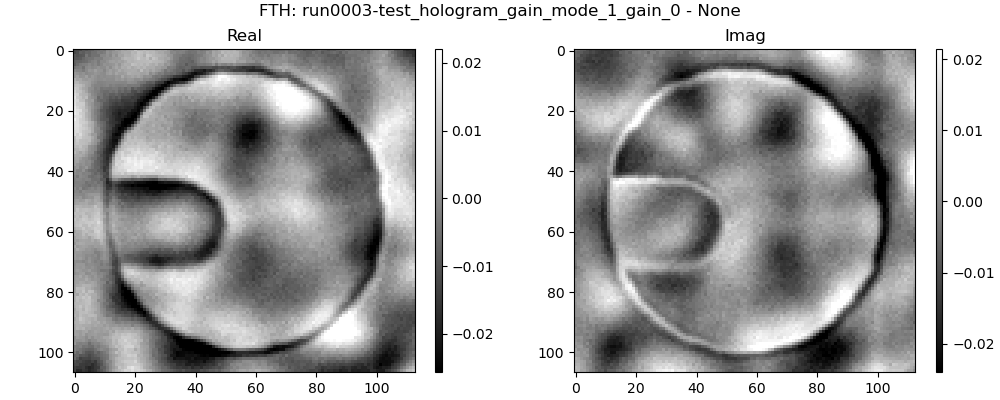

In [58]:
# Create plot
holo = diff_c * mask_bs * (1 - mask_pixel_smooth)

# Reconstruct
recon = fth.reconstruct(
    fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)

# Create plot
title = get_title(None, im_id, topo_id)
plot_recon(recon[roi_s], title)

# Save images
fname = join(
    folder_target,
    "Recon_ImId_%s_RefId_%s_%s.png"
    % (
        im_id,
        topo_id,
        USER,
    ),
)
print("Saving: %s" % fname)
plt.savefig(fname, bbox_inches="tight", transparent=False)

# Save hdf5 file
save_fth_h5()

In [59]:
# Closes all existing plots
plt.close("all")

# Load parameter from logfile

In [ ]:
# Define scans for each image
# Images
run_nr = "run0001-test_axis"
acq_nr = 1
im_id = get_im_id(run_nr, acq_nr)

# Topos
run_nr = "run0001-test_axis"
acq_nr = 2
topo_id = get_im_id(run_nr, acq_nr)

# Define scan ids for each image
dark_id = None

print("Loading Image: %s" % im_id)
print("Loading Topo: %s" % topo_id)

In [ ]:
data = load_fth(im_id, topo_id)
roi = data["roi"]
roi_s = np.s_[roi[0] : roi[1], roi[2] : roi[3]]
center = data["center"]
prop_dist = data["prop_dist"]
phase = data["phase"]
mask_draw = data["mask_draw"]
mask_bs = data["mask_bs"]
mask_pixel = data["mask_pixel"]
mask_pixel_smooth = data["mask_pixel_smooth"]

# Batch processing FTH

In [ ]:
# Define scans for each image
# Images
run_nr = "run0001-test_axis"
acq_nr = 1
im_id = get_im_id(run_nr, acq_nr)

# Topos
run_nr = "run0001-test_axis"
acq_nr = 1
topo_id = get_im_id(run_nr, acq_nr)

# Define scan ids for each image
dark_id = None

print("Loading Image: %s" % im_id)
print("Loading Topo: %s" % topo_id)

In [ ]:
# Define the sets for reconstructions. You can make a list or use np.arange
# im_id_set should always have ids of positive helicity holograms,
# topo_id_set those of negative helicity or a hologram of a saturated state

# You can also use nested lists:
# in case topo_id_set = [[id1,id2],id3 it will use the sum hologram
# calculated from [id1,id2] as topo

im_id_set = [im_id]
dark_id_set = [None]
topo_id_set = [topo_id]

# In case of single helicity reconstructions, adapt the helicity
# for contrast inversion
helicity = 1 * np.ones(len(im_id_set), dtype=int)  # [1,-1]

print("Dynamics Set:  %s" % im_id_set)
print("Reference Set: %s" % topo_id_set)
print("Helicity: %s" % helicity)

In [ ]:
# less ugly Automatic processing of image stacks
recons_name = []  # for gifs
for it, im_id in enumerate(im_id_set):
    print(im_id)
    # Load images
    _, image, _ = load_processing(im_id)

    # Get topo
    topo_id = topo_id_set[it]
    _, topo, _ = load_processing(topo_id)

    # Load dark
    dark_id = dark_id_set[it]
    if dark_id is not None:
        _, dark, _ = load_processing(dark_id, crop=None)
        image = image - dark
        topo = topo - dark

    # Process images
    worker_dict = worker(image, topo)

    # Extract parameter from reco
    recon = worker_dict["recon"]
    topo_c = worker_dict["topo_c"]
    sum_c = worker_dict["sum_c"]
    diff_c = worker_dict["diff_c"]
    im_c = worker_dict["im_c"]
    holo = worker_dict["diff_c"]
    shift = worker_dict["shift"]
    factor = worker_dict["factor"]
    offset = worker_dict["offset"]

    # Plot
    title = get_title(None, im_id, topo_id, CDI=False)
    plot_recon(recon[roi_s], title)

    # Save images
    fname = join(
        folder_target,
        "Recon_ImId_%s_RefId_%s_%s_batch.png"
        % (
            split_im_id(im_id)[0] + "_" + split_im_id(im_id)[1],
            split_im_id(topo_id)[0] + "_" + split_im_id(topo_id)[1],
            USER,
        ),
    )
    print("Saving: %s" % fname)
    plt.savefig(fname, bbox_inches="tight", transparent=False)

    # Optional: Save hdf5 file of fth data
    save_fth_h5()

    print(" ")
print("FTH stack processing finished")

# CDI Reconstruction

## Create set of pos and neg helicity holograms

CDI algorithm needs holograms recorded wih both helicity ($\sigma = \pm 1$) as input. We use will calculate those from our previously centered and intensity normalized holograms according to;´; 

$Image(\sigma) = Topo + \sigma \cdot diff $,

In [105]:
# Copy values from FTH reco (here topo = sum_c)
pos = (sum_c + diff_c) / 2
neg = (sum_c - diff_c) / 2

NameError: name 'sum_c' is not defined

## Create Support mask

The support mask is the real-space constraint used for the (holographically-aided) phase retrieval, i.e., certain details about our sample like the sample geometry. For our samples we can directly derive a very strong constraint: The FTH reconstructions show us previsely the actual real-space sample structure, i.e., the arrangement of our aperture where x-rays are transmitted ("1") while the masked areas show no transmission ("0"). We will therefore create a binary mask that reflects this transmission as an input for the phase retrieval.

How to draw a support mask: Create a binary mask of the locations of sample apertures in the fth reconstruction. Areas with apertures are "1". Select only a single set of reconstructions (object & reference apertures) that originate from a single reference. Use the widget!

### Option 1: Execute if you want to create a new support mask with circle mask widget

If you really want to create a new support mask, execute next cell and then the "InteractiveCircleCoordinates"-widget

Cover the object & reference apertures for each set of reconstructions that originates from the same reference with circles.
Optimization: Change one circle parameter, calc phase retrieval image, compare with images reconstructed with old circle parameter. Repeat!
Use circle index slider to change between circles. The active circle is highlighted in red.
Right click to move circle to mouse position!


interactive(children=(FloatRangeSlider(value=(-0.30329194078763555, 0.28310420846360135), description='contras…

interactive(children=(IntSlider(value=0, description='index', max=3), Output()), _dom_classes=('widget-interac…

interactive(children=(FloatSlider(value=7.0, description='radius', layout=Layout(width='350px'), max=400.0, st…

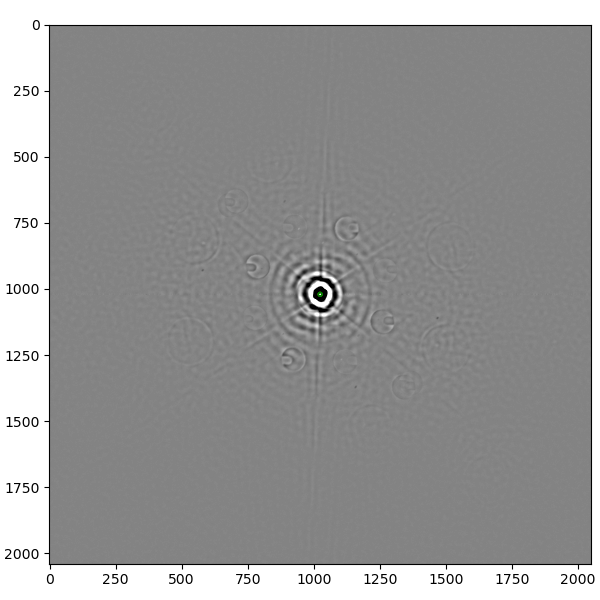

In [107]:
# How many references do you have?
nr_ref = 3

# Setup coordinates (nr_ref + 1 coordinates, as there is always the object aperture)
support_coordinates = [
    [pos.shape[-2] // 2, pos.shape[-1] // 2, 7] for k in range(nr_ref + 1)
]

# Widget to find the positions and sizes of the different apertures
print(
    "Cover the object & reference apertures for each set of reconstructions that originates from the same reference with circles."
)
print(
    "Optimization: Change one circle parameter, calc phase retrieval image, compare with images reconstructed with old circle parameter. Repeat!"
)

# Create plot
holo = diff_c * mask_bs * (1 - mask_pixel_smooth)

# Reconstruct
recon = fth.reconstruct(
    fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)
recon = np.abs(recon)

ds = interactive.InteractiveCircleCoordinates(
    np.real(
        fth.reconstruct(pos * mask_bs * np.exp(1j * phase) * (1 - mask_pixel_smooth))
    ),
    len(support_coordinates),
    coordinates=support_coordinates.copy(),
)

Text(0.5, 1.0, 'Image with overlayed mask')

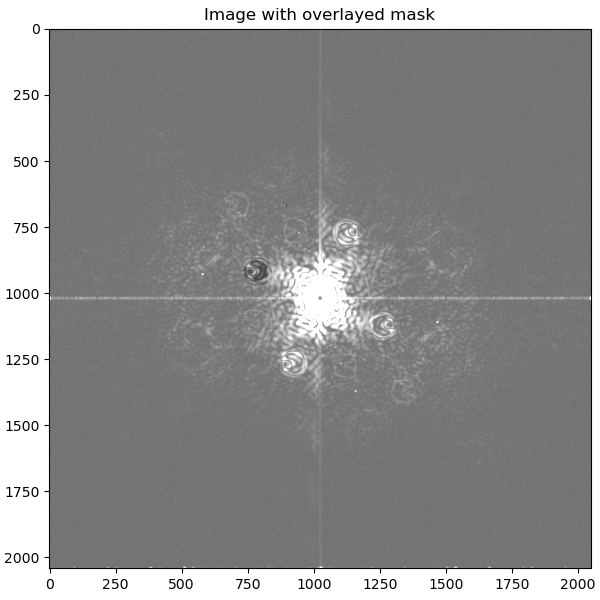

In [108]:
# Take coordinates of circles from widget
support_coordinates = ds.get_params()

# Create supportmask from coordinates
supportmask = mask_lib.create_circle_supportmask(support_coordinates, pos.shape)

# Plot supportmask as overlay
fig, ax = plt.subplots(figsize=(6, 6))
mi, ma = np.percentile(recon, (1, 99))
ax.imshow(recon, vmin=mi, vmax=ma, cmap="gray")
ax.imshow(supportmask, alpha=0.4, cmap="binary")
ax.set_title("Image with overlayed mask")

### Option 2: Execute if you want to load an existing support mask

In [ ]:
def get_supportmask_coordinates(sample):
    """
    Dictionary that stores coordinates of circular support mask apertures
    """

    # Setup dictonary
    support_coord = dict()

    # coordinates
    support_coord["s2311e-C3"] = [
        (723.0, 637.0, 105.5),
        (773.5, 1276.0, 7.0),
        (1062.5, 835.0, 7.0),
        (1152.0, 1183.0, 7.0),
    ]

    return support_coord[sample]

In [ ]:
# Which supportmask to load? ("s2306a-C1", "s2308a-B1", ...)
sample = "s2311e-C3"

# Get coordinates and create supportmask
support_coordinates = get_supportmask_coordinates(sample)

In [ ]:
# Widget to find the positions and sizes of the different apertures
print(
    "Cover the object & reference apertures for each set of reconstructions that originates from the same reference with circles."
)
print(
    "Optimization: Change one circle parameter, calc phase retrieval image, compare with images reconstructed with old circle parameter. Repeat!"
)

# Plotting image
holo = sum_c * mask_bs * (1 - mask_pixel_smooth)

# Reconstruct
recon = fth.reconstruct(
    fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)
recon = np.abs(recon)

ds = interactive.InteractiveCircleCoordinates(
    recon,
    len(support_coordinates),
    coordinates=support_coordinates,
)

In [ ]:
# Take coordinates of circles from widget
support_coordinates = ds.get_params()

# Create supportmask from coordinates
supportmask = mask_lib.create_circle_supportmask(support_coordinates, pos.shape)

# Plot supportmask as overlay
fig, ax = plt.subplots(figsize=(6, 6))
mi, ma = np.percentile(recon, (1, 99))
ax.imshow(recon, vmin=mi, vmax=ma, cmap="gray")
ax.imshow(supportmask, alpha=0.4, cmap="binary")
ax.set_title("Image with overlayed mask")

### Take Roi
Choose the reconstructions as the ROI.

1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

In [ ]:
fig, ax = cimshow(supportmask.astype(int))

In [ ]:
roi_cdi = interactive.axis_to_roi(ax)
# roi_cdi = [354, 557, 983, 1193]
# roi_cdi = np.s_[roi_cdi[0] : roi_cdi[1], roi_cdi[2] : roi_cdi[3]]
print("Sliced roi:", roi_cdi)

## Do Phase Retrieval

In [ ]:
# Executes the algorithm
offset_vmin = 0.5
recon = fth.reconstruct(
    fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)
Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(supportmask * recon)))
Startimage = None
Startgamma = None

(
    retrieved_p,
    retrieved_n,
    retrieved_p_pc,
    retrieved_n_pc,
    bsmask_p,
    bsmask_n,
    gamma_p,
    gamma_n,
) = phase_retrieval(
    pos,
    neg,
    mask_pixel.astype(int),
    supportmask,
    vmin=offset_vmin,
    Startimage=Startimage,
    Startgamma=Startgamma,
)

## Reconstruct images from phase retrieval

In [ ]:
# New beamstop for CDI recos as phase retrieval of low-q might be insufficient. If phase retrieval worked well
# Try without beamstop: `use_bs = False`
use_bs = False
bs_diam_cdi = 25  # diameter of beamstop

# Create beamstop
if use_bs is True:
    mask_bs_cdi = 1 - cci.circle_mask(
        pos.shape, np.array(pos.shape) / 2, bs_diam_cdi, sigma=4
    )
    mask_bs_cdi = 1 - mask_pixel_smooth.copy()
elif use_bs is False:
    mask_bs_cdi = np.ones(pos.shape)  # if you don't want a beamstop

# Get Recos
# Positive helicity
p = cci.reconstruct(
    fth.propagate(
        retrieved_p * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# Negative helicity
n = cci.reconstruct(
    fth.propagate(
        retrieved_n * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)


# Get Recos partial coherence
# Positiv partial coherence
p_pc = cci.reconstruct(
    fth.propagate(
        retrieved_p_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# Negative partial coherence
n_pc = cci.reconstruct(
    fth.propagate(
        retrieved_n_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# optimize phase
recon = p_pc - n_pc
# _, phase_cdi = optimize_phase_contrast(recon, supportmask, method="contrast",prefered_color="white")

# Plotting
mode = "-"
print("Fine-tuning of reconstruction parameter:")
slider_prop, slider_phase, slider_dx, slider_dy = rec.focusCDI(
    retrieved_p_pc * mask_bs_cdi,
    retrieved_n_pc * mask_bs_cdi,
    # retrieved_p * mask_bs_cdi,
    # retrieved_n * mask_bs_cdi,
    roi_cdi,
    mask=supportmask,
    phase=phase_cdi,
    dx=dx,
    dy=dy,
    prop_dist=prop_dist_cdi,
    experimental_setup=experimental_setup,
    operation=mode,
    max_prop_dist=20,
    scale=(1, 99),
)

In [ ]:
# Get phase from slider
phase_cdi = slider_phase.value
prop_dist_cdi = slider_prop.value

# Reconstruct images with new parameter
p_pc = fth.reconstructCDI(
    fth.propagate(
        retrieved_p_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
) * np.exp(1j * phase_cdi)

n_pc = fth.reconstructCDI(
    fth.propagate(
        retrieved_n_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
) * np.exp(1j * phase_cdi)


print("Phase CDI: %s" % phase_cdi)
print("Prop_dist: %s" % prop_dist_cdi)

In [ ]:
# Confirm that offset subtraction in cdi function works, i.e., only small fraction of hologram is actually masked
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
tmp = np.abs(retrieved_p_pc * mask_bs_cdi)
mi, ma = np.percentile(tmp, [0.1, 99.9])
ax[0, 0].imshow(tmp, vmin=mi, vmax=ma)
ax[0, 0].set_title("Pos holo")

tmp = np.abs(retrieved_n_pc)
mi, ma = np.percentile(tmp, [0.1, 99.9])
ax[0, 1].imshow(tmp, vmin=mi, vmax=ma)
ax[0, 1].set_title("Neg holo")
ax[1, 0].imshow(bsmask_p)
ax[1, 0].set_title("Pos holo mask")
ax[1, 1].imshow(bsmask_n)
ax[1, 1].set_title("Neg holo mask")

## Save reconstructions

In [ ]:
def plot_recon(recon, title):
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title)

    vmin, vmax = np.percentile(np.real(recon), (0.1, 99.9))
    t_im1 = ax[0].imshow(np.real(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[0].set_title("Real")
    plt.colorbar(t_im1, ax=ax[0], aspect=50)

    vmin, vmax = np.percentile(np.imag(recon), (0.1, 99.9))
    t_im2 = ax[1].imshow(np.imag(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[1].set_title("Imag")
    plt.colorbar(t_im2, ax=ax[1], aspect=50)

In [ ]:
# Saves only real and imaginary part
# recon = p - n
recon = p_pc - n_pc  #   / (p_pc + n_pc)

# Plot
title = get_title(None, im_id, topo_id, CDI=True)
# plot_recon(np.rot90(recon,-2)[roi_cdi], title)
plot_recon(recon[roi_cdi], title)

# Save images
fname = join(
    folder_target,
    "Recon_ImId_%s_RefId_%s_%s_cdi.png"
    % (
        split_im_id(im_id)[0] + "_" + split_im_id(im_id)[1],
        split_im_id(topo_id)[0] + "_" + split_im_id(topo_id)[1],
        USER,
    ),
)
print("Saving: %s" % fname)
plt.savefig(fname, bbox_inches="tight", transparent=False)

# Save h5
save_cdi_h5()

# Batch processing CDI

## Define Scan Ids

In [ ]:
# Load support mask of which sample?
sample = "s2311e-C3"

In [ ]:
# Define scans for each image
# Images
run_nr = "run0001-test_axis"
acq_nr = 1
im_id = get_im_id(run_nr, acq_nr)

# Topos
run_nr = "run0001-test_axis"
acq_nr = 1
topo_id = get_im_id(run_nr, acq_nr)

# Define scan ids for each image
dark_id = None

print("Loading Image: %s" % im_id)
print("Loading Topo: %s" % topo_id)

In [ ]:
# Define the sets for reconstructions. You can make a list or use np.arange
# im_id_set should always have ids of positive helicity holograms,
# topo_id_set those of negative helicity or a hologram of a saturated state

# You can also use nested lists:
# in case topo_id_set = [[id1,id2],id3 it will use the sum hologram
# calculated from [id1,id2] as topo

im_id_set = [im_id]
dark_id_set = [None]
topo_id_set = [topo_id]

# In case of single helicity reconstructions, adapt the helicity
# for contrast inversion
helicity = 1 * np.ones(len(im_id_set), dtype=int)  # [1,-1]

print("Dynamics Set:  %s" % im_id_set)
print("Reference Set: %s" % topo_id_set)
print("Helicity: %s" % helicity)

## Execute Phase Retrieval

In [ ]:
# Ugly Automatic processing of image stacks
recons_name = []  # for gifs
for it, im_id in enumerate(tqdm(im_id_set)):
    # Load images
    _, image, _ = load_processing(im_id)

    # Get topo
    topo_id = topo_id_set[it]
    _, topo, _ = load_processing(topo_id)

    # Load dark
    dark_id = dark_id_set[it]
    if dark_id is not None:
        _, dark, _ = load_processing(dark_id, crop=None)
        image = image - dark
        topo = topo - dark

    # Process images
    worker_dict = worker(image, topo)

    # Extract parameter from reco
    recon = worker_dict["recon"]
    topo_c = worker_dict["topo_c"]
    sum_c = worker_dict["sum_c"]
    diff_c = worker_dict["diff_c"]
    im_c = worker_dict["im_c"]
    holo = worker_dict["diff_c"]
    shift = worker_dict["shift"]
    factor = worker_dict["factor"]
    offset = worker_dict["offset"]

    # Plot
    title = get_title(None, im_id, topo_id, CDI=False)
    plot_recon(recon[roi_s], title)

    # Save images
    fname = join(
        folder_target,
        "Recon_ImId_%s_RefId_%s_%s_batch.png"
        % (
            split_im_id(im_id)[0] + "_" + split_im_id(im_id)[1],
            split_im_id(topo_id)[0] + "_" + split_im_id(topo_id)[1],
            USER,
        ),
    )
    print("Saving: %s" % fname)
    plt.savefig(fname, bbox_inches="tight", transparent=False)

    # Optional: Save hdf5 file of fth data
    save_fth_h5()

    ################ CDI ###############
    # Create pos and neg helicity set
    pos = (worker_dict["sum_c"] + worker_dict["diff_c"]) / 2
    neg = (worker_dict["sum_c"] - worker_dict["diff_c"]) / 2

    # Create mask pixel
    mask_im = worker_dict["mask_pixel"]
    mask_topo = mask_im.copy()

    # Get coordinates and create supportmask
    support_coordinates = get_supportmask_coordinates(sample)
    supportmask = mask_lib.create_circle_supportmask(support_coordinates, pos.shape)

    # Do phase retrieval
    (
        retrieved_p,
        retrieved_n,
        retrieved_p_pc,
        retrieved_n_pc,
        bsmask_p,
        bsmask_n,
        gamma_p,
        gamma_n,
    ) = phase_retrieval(
        pos,
        neg,
        mask_pixel,
        supportmask,
        vmin=offset_vmin,
        Startimage=Startimage,
        Startgamma=Startgamma,
    )

    # Get Recos partial coherence
    # Positiv partial coherence
    p_pc = fth.reconstructCDI(
        fth.propagate(
            retrieved_p_pc * mask_bs_cdi,
            prop_dist_cdi * 1e-6,
            experimental_setup=experimental_setup,
        )
    )
    # Negative partial coherence
    n_pc = fth.reconstructCDI(
        fth.propagate(
            retrieved_n_pc * mask_bs_cdi,
            prop_dist_cdi * 1e-6,
            experimental_setup=experimental_setup,
        )
    )

    ##### Calc reco and optimze contrast
    recon = helicity[it] * (p_pc - n_pc)
    _, phase_cdi = optimize_phase_contrast(recon, supportmask, method="contrast")
    # phase_cdi = 0
    recon = recon * np.exp(1j * phase_cdi)
    print("Phase is:", np.round(phase_cdi, 2))
    ########

    # Plot
    title = get_title(None, im_id, topo_id, CDI=True)
    plot_recon(recon[roi_cdi], title)

    # Save images
    fname = join(
        folder_target,
        "Recon_ImId_%s_RefId_%s_%s_cdi_batch.png"
        % (
            split_im_id(im_id)[0] + "_" + split_im_id(im_id)[1],
            split_im_id(topo_id)[0] + "_" + split_im_id(topo_id)[1],
            USER,
        ),
    )

    print("Saving: %s" % fname)
    plt.savefig(fname, bbox_inches="tight", transparent=False)
    recons_name.append(fname)

    # Save files as h5
    save_cdi_h5()

    print(" ")
print("CDI stack processing finished")

In [ ]:
plt.close("all")